In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import warnings
import logging


tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.4


In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
x_train_val= np.load('/kaggle/input/time-series/x_train.npy')
y_train_val=np.load('/kaggle/input/time-series/y_train.npy')

In [4]:
print("X_train shape",x_train_val.shape)
print("Y_train shape",y_train_val.shape)

X_train shape (2429, 36, 6)
Y_train shape (2429,)


In [5]:
labels={0: "Wish",
1: "Another",
2: "Comfortably",
3: "Money",
4: "Breathe",
5: "Time",
6: "Brain",
7: "Echoes",
8: "Wearing",
9: "Sorrow",
10: "Hey",
11: "Shine"}

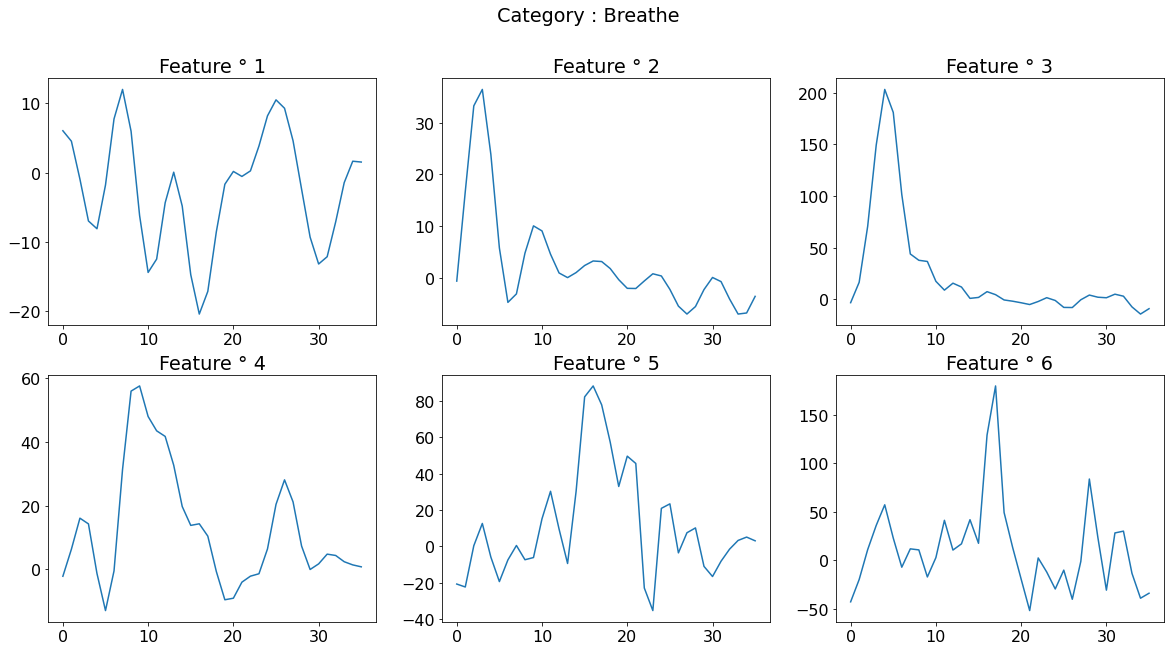

In [6]:
# UNDERSTANDING THE DATA : VISUALIZE

# At first it appears like: the data is represented on 36 pts time series, and for 
# each point of time there is a value for 6 different features; it is then 36 pts 
# time series of 6 different features

def plot_example(random_index, x,y ):
    example=x[random_index]
    example_label=y[random_index]

    n_points=example.shape[0] # 36
    n_features=example.shape[1] # 6

    counter=0
    fig, axs= plt.subplots(2, 3, figsize=(20,10))
    fig.suptitle('Category : '+labels[example_label])
    for i in range(n_features):
        row= counter//3
        col= counter%3
        example_on_ith_feature=example[:,i]
        axs[row,col].set_title('Feature ° '+str(i+1))
        axs[row,col].plot(example_on_ith_feature)
        counter=counter+1




random_index=np.random.randint(0,2428) 
plot_example(random_index,x_train_val,y_train_val)


TOTAL :  2429


<BarContainer object of 12 artists>

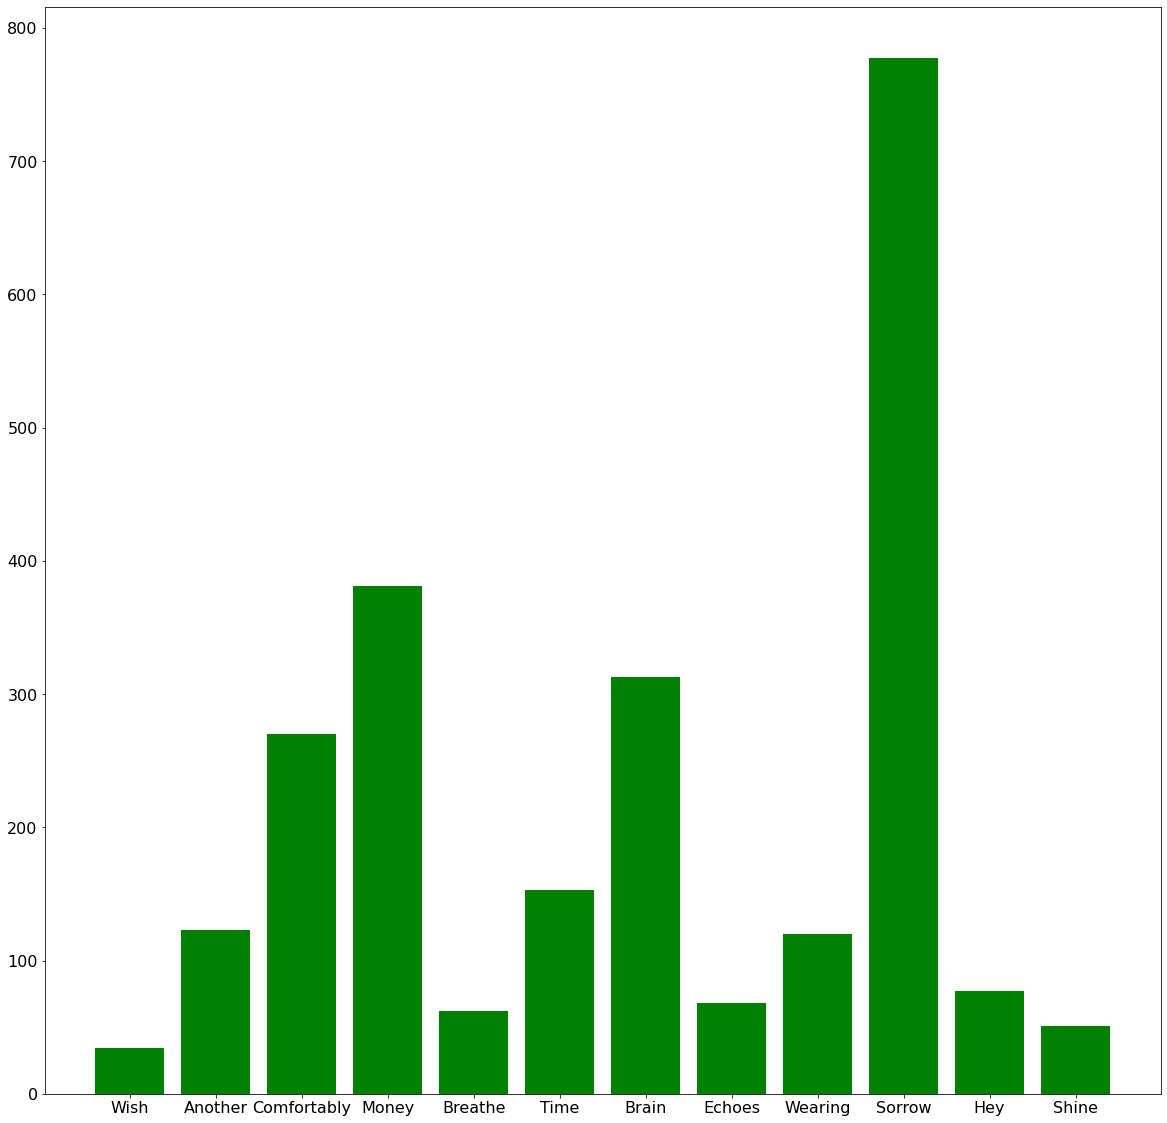

In [7]:
# CLASS REPARTITIONS


class_repartitions={"Wish":0,
"Another":0,
"Comfortably":0,
"Money":0,
"Breathe":0,
"Time":0,
"Brain":0,
"Echoes":0,
"Wearing":0,
"Sorrow":0,
"Hey":0,
"Shine":0}

for y in y_train_val:
    label=labels[y]
    class_repartitions[label]=class_repartitions[label]+1
    
S=0
for key in class_repartitions:
    S=S+class_repartitions[key]


print("TOTAL : ",S)
plt.figure(figsize=(20,20))
plt.bar(class_repartitions.keys(), class_repartitions.values(), color='g')


# ===> UNBALANCED DATASET

In [11]:
n_total=x_train_val.shape[0]
n_classes=12


class_loss_weights = {
    class_number: (1 / class_repartitions[labels[class_number]]) * (n_total / 12) for class_number in range(12)
}

class_loss_weights

{0: 5.953431372549019,
 1: 1.6456639566395665,
 2: 0.7496913580246913,
 3: 0.5312773403324584,
 4: 3.264784946236559,
 5: 1.3229847494553377,
 6: 0.6466986155484558,
 7: 2.9767156862745097,
 8: 1.6868055555555554,
 9: 0.2605105105105105,
 10: 2.628787878787879,
 11: 3.9689542483660127}

In [172]:
# WORKING THE DATA IN AMOUNT

In [ ]:
# PREPROCESSING

In [40]:
# Studiying each feature/variable separately (statistics, distribution, boxplots ...)

x_train_val_flattened =[]
y_train_val_flattened=[]

for i in range(n_total):
    for k in range(36):
        x_train_val_flattened.append([])
        y_train_val_flattened.append(y_train_val[i])
        for f in range(6):
            x_train_val_flattened[len(x_train_val_flattened)-1].append(x_train_val[i,k,f])

x_train_val_flattened=np.array(x_train_val_flattened)           


df=pd.DataFrame(x_train_val_flattened)
df["class"] = y_train_val_flattened
df["class_name"] = [ labels[y] for y in y_train_val_flattened]

In [42]:
df

,0,1,2,3,4,5,class,class_name
0,17.59700,8.17130,-1.78420,-19.70600,-9.71350,-61.8870,0,Wish
1,0.22974,-5.89560,16.83700,5.03900,2.43320,58.9140,0,Wish
2,-29.65400,-21.29600,29.10300,-0.47503,75.39100,10.6650,0,Wish
3,-59.21000,-29.56500,17.97100,-45.60600,19.41200,-43.0140,0,Wish
4,-72.06400,-25.85500,0.46536,-59.15100,-29.10500,-11.9130,0,Wish
...,...,...,...,...,...,...,...,...
87439,3.51190,-1.03240,-1.69900,4.15790,2.75430,5.9823,11,Shine
87440,0.70853,-0.94622,-1.91760,2.09480,-4.76750,7.4118,11,Shine
87441,0.20638,1.02870,-0.92512,-0.71633,1.73330,4.7638,11,Shine
87442,4.14290,1.09390,-0.18921,1.14100,0.93441,4.1742,11,Shine


In [52]:
# Some info on the dataset

df[[0,1,2,3,4,5]].describe()

,0,1,2,3,4,5
count,87444.000000,87444.000000,87444.000000,87444.000000,87444.000000,87444.000000
mean,9.571373,17.942852,26.531002,32.373994,33.874759,31.481785
std,250.301522,776.638186,699.091261,681.845382,669.444098,730.158730
min,-3420.000000,-11585.000000,-10289.000000,-8009.900000,-7326.600000,-7584.100000
25%,-3.574775,-1.703225,-1.704875,-2.474225,-4.052300,-8.470850
50%,0.275515,0.410780,0.652080,0.944095,1.286750,2.114050
75%,5.568825,4.117225,6.932275,9.922200,14.084250,20.723000
max,32932.000000,44394.000000,37032.000000,38086.000000,38490.000000,53020.000000


In [ ]:
# Taking outliers into account for scaling : ROBUST SCALER !!!!



In [67]:
from sklearn.preprocessing import RobustScaler

transformer = RobustScaler()
transformer.fit(x_train_val_flattened)
medians=transformer.center_
IQR=transformer.scale_
print("medians values : ",medians)
print("IQR ranges : ", IQR)


x_train_val_scaled = x_train_val.copy()

for i in range(n_total):
    x_train_val_scaled[i]=transformer.transform(x_train_val_scaled[i])

print()
print("Verification : ")
print(" original : " ,x_train_val[0][0])
print(" robust scaled : " ,x_train_val_scaled[0][0])
should_be = []
for f in range(6):
    s=(x_train_val[0][0][f] - medians[f])/IQR[f]
    should_be.append(s.round(7))
print(" should be : " ,should_be)
print()

print("Robust Scaling works well after verification.")

medians values :  [0.275515 0.41078  0.65208  0.944095 1.28675  2.11405 ]
IQR ranges :  [ 9.1436    5.82045   8.63715  12.396425 18.13655  29.19385 ]

Verification : 
 original :  [ 17.597    8.1713  -1.7842 -19.706   -9.7135 -61.887 ]
 robust scaled :  [ 1.8943835   1.33331959 -0.2820699  -1.66581051 -0.60652384 -2.19227851]
 should be :  [1.8943835, 1.3333196, -0.2820699, -1.6658105, -0.6065238, -2.1922785]


ORIGINAL :


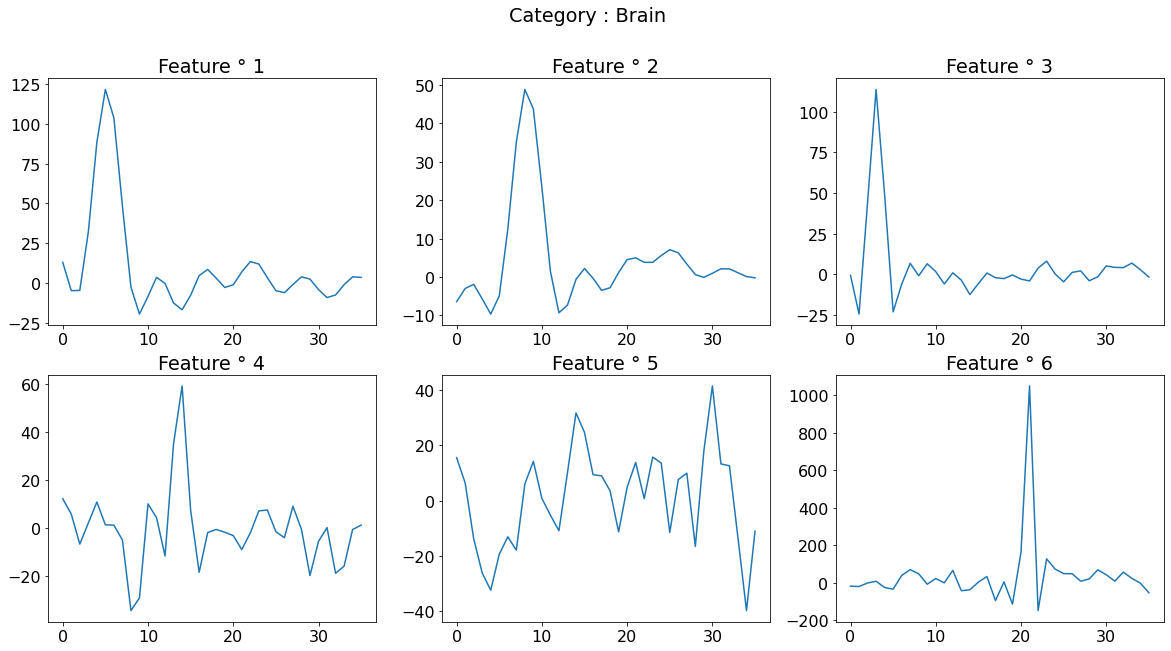

In [69]:
# Verification of the scaling impact on some examples

random_index=np.random.randint(0,2428) 

print("ORIGINAL :")
plot_example(random_index,x_train_val,y_train_val)

NORMALIZED :


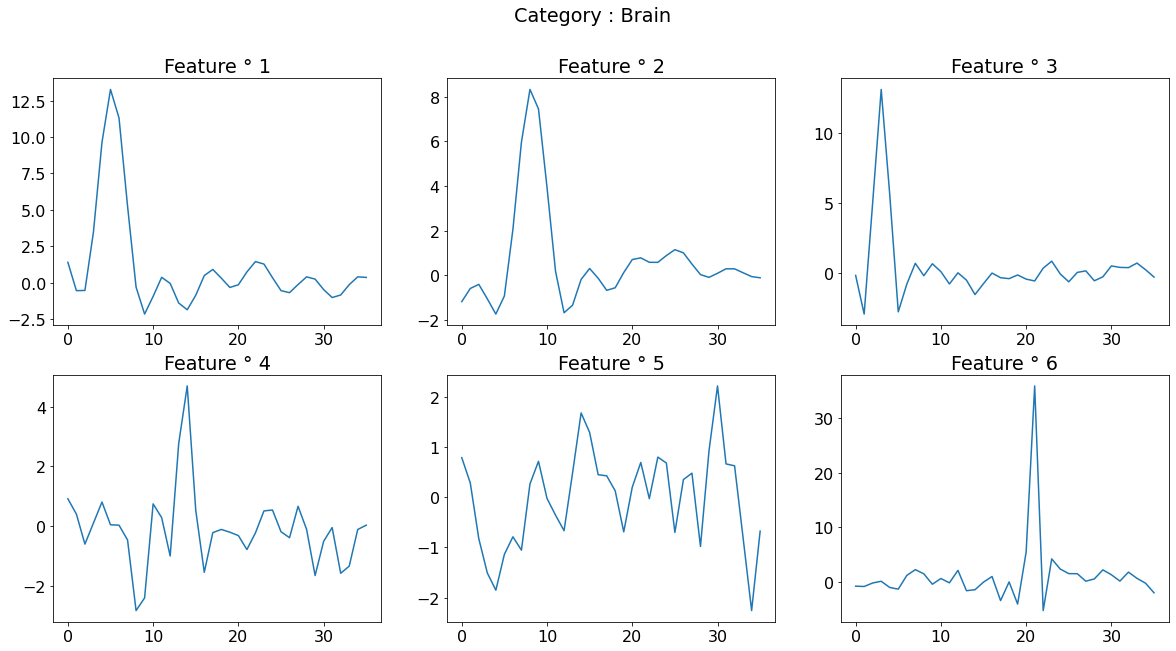

In [70]:
print("NORMALIZED :")
plot_example(random_index,x_train_val_scaled,y_train_val)

In [72]:
# SPLITTING

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train_val,y_train_val, test_size = 0.1, random_state=seed,stratify= y_train_val )

In [73]:
print(x_train.shape, x_val.shape)
print(y_train.shape, y_val.shape)

(2186, 36, 6) (243, 36, 6)
(2186,) (243,)


In [ ]:
# Checking repartitions after split, to see if it conserves repartition 

TRAINING SPLIT REPARTITION
TOTAL :  2186


<BarContainer object of 12 artists>

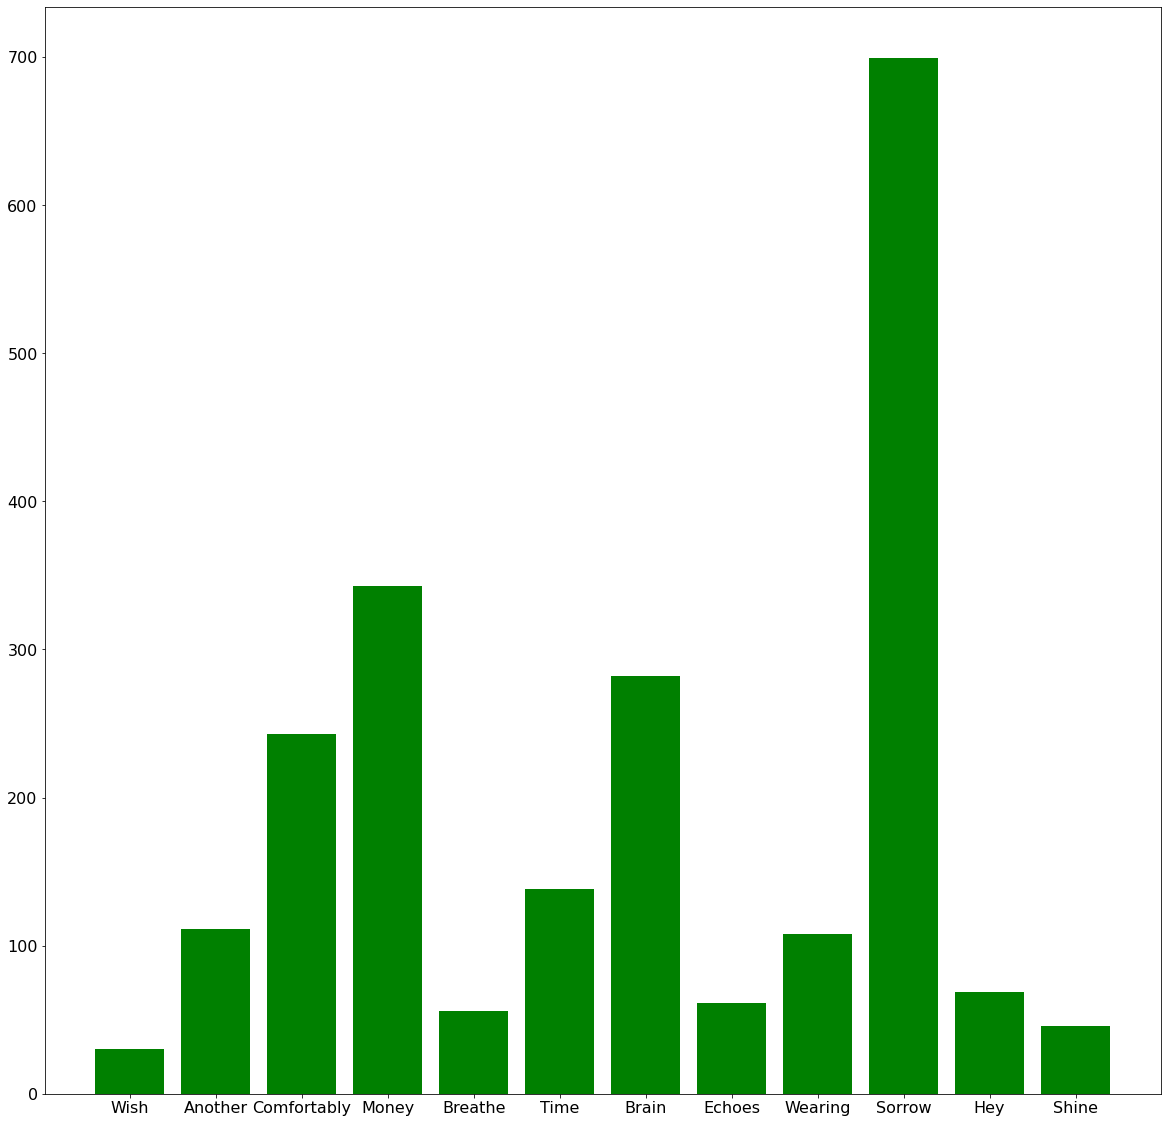

In [74]:
train_class_repartitions={"Wish":0,
"Another":0,
"Comfortably":0,
"Money":0,
"Breathe":0,
"Time":0,
"Brain":0,
"Echoes":0,
"Wearing":0,
"Sorrow":0,
"Hey":0,
"Shine":0}

for y in y_train:
    label=labels[y]
    train_class_repartitions[label]=train_class_repartitions[label]+1
    
S=0
for key in train_class_repartitions:
    S=S+train_class_repartitions[key]

print( "TRAINING SPLIT REPARTITION")
print("TOTAL : ",S)
plt.figure(figsize=(20,20))
plt.bar(train_class_repartitions.keys(), train_class_repartitions.values(), color='g')

VALIDATION SPLIT REPARTITION
TOTAL :  243


<BarContainer object of 12 artists>

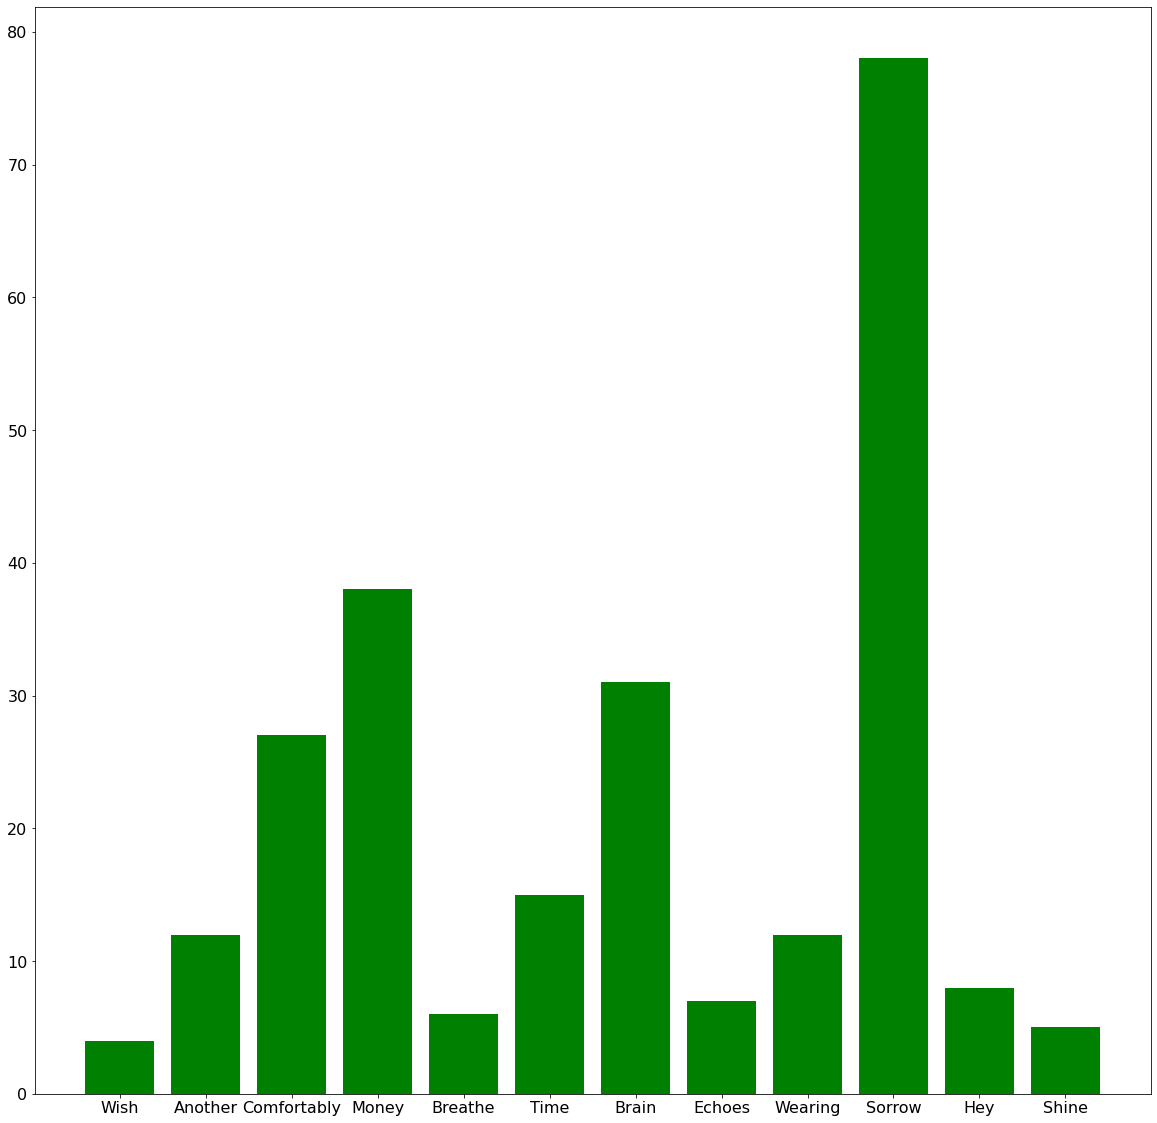

In [75]:
val_class_repartitions={"Wish":0,
"Another":0,
"Comfortably":0,
"Money":0,
"Breathe":0,
"Time":0,
"Brain":0,
"Echoes":0,
"Wearing":0,
"Sorrow":0,
"Hey":0,
"Shine":0}

for y in y_val:
    label=labels[y]
    val_class_repartitions[label]=val_class_repartitions[label]+1
    
S=0
for key in val_class_repartitions:
    S=S+val_class_repartitions[key]

print( "VALIDATION SPLIT REPARTITION")
print("TOTAL : ",S)
plt.figure(figsize=(20,20))
plt.bar(val_class_repartitions.keys(), val_class_repartitions.values(), color='g')

In [76]:
# Encoding target variable

y_train_categorical = tfk.utils.to_categorical(y_train)
y_val_categorical =  tfk.utils.to_categorical(y_val)

print(y_train_categorical.shape,y_val_categorical.shape )

(2186, 12) (243, 12)


In [45]:
# MODEL BUILDING

In [77]:
input_shape = x_train.shape[1:]
classes = y_train_categorical.shape[-1]
batch_size = 128
epochs = 200

In [78]:
def basic_LSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    lstm = tfkl.LSTM(128, return_sequences=True)(input_layer)
    lstm2 = tfkl.LSTM(128)(lstm)
    dropout = tfkl.Dropout(.5, seed=seed)(lstm2)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [93]:
model = basic_LSTM_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 36, 6)]           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 36, 128)           69120     
_________________________________________________________________
lstm_9 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_9 (Dense)              (None, 12)                1548      
Total params: 218,764
Trainable params: 218,764
Non-trainable params: 0
_______________________________________________________

In [ ]:
# TRAINING PHASE

In [94]:
# Train the model
history = model.fit(
    x = x_train,
    y = y_train_categorical,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(x_val, y_val_categorical),
     callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=10, factor=0.5, min_lr=1e-5)
    ]
   
).history

Epoch 1/200
18/18 [==============================] - 8s 225ms/step - loss: 2.1475 - accuracy: 0.3385 - val_loss: 1.8119 - val_accuracy: 0.4444
Epoch 2/200
18/18 [==============================] - 3s 171ms/step - loss: 1.7217 - accuracy: 0.4405 - val_loss: 1.4867 - val_accuracy: 0.4733
Epoch 3/200
18/18 [==============================] - 3s 166ms/step - loss: 1.4815 - accuracy: 0.4991 - val_loss: 1.4307 - val_accuracy: 0.4897
Epoch 4/200
18/18 [==============================] - 3s 193ms/step - loss: 1.3285 - accuracy: 0.5480 - val_loss: 1.2985 - val_accuracy: 0.5350
Epoch 5/200
18/18 [==============================] - 3s 168ms/step - loss: 1.2113 - accuracy: 0.5988 - val_loss: 1.2386 - val_accuracy: 0.5638
Epoch 6/200
18/18 [==============================] - 3s 161ms/step - loss: 1.1545 - accuracy: 0.6112 - val_loss: 1.3042 - val_accuracy: 0.5720
Epoch 7/200
18/18 [==============================] - 3s 160ms/step - loss: 1.2022 - accuracy: 0.5938 - val_loss: 1.2726 - val_accuracy: 0.5802

Confusion Matrix


TypeError: object of type 'int' has no len()

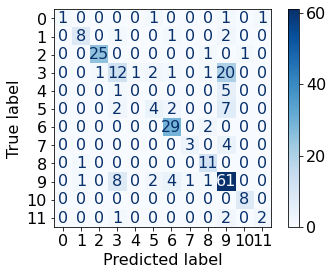

In [101]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

#Confution Matrix and Classification Report
# Y_pred = model_gap.predict_generator(valid_gen,  706// batch_size+1)
Y_pred = model.predict(x_val)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm=confusion_matrix(y_val, y_pred)

disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

print(classification_report(y_val, y_pred, target_names=labels))

In [102]:
import shutil

model.save('LSTM')
shutil.make_archive("LSTM", 'zip', './LSTM')

'/kaggle/working/LSTM.zip'